In [52]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.api as sm2
import statistics as stat
from numpy.random import normal
from numba import njit
import seaborn as sns
import pylab
from scipy import optimize as opt
from scipy import stats as st
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

# Probelm 1

## OLS Implementation:

In [53]:
#load data
df=pd.read_csv("https://raw.githubusercontent.com/dompazz/FinTech590-RiskManagement/main/Week02/Project/problem1.csv")

In [54]:
df

,x,y
0,-1.166289,1.014680
1,-0.426878,0.262715
2,-1.477892,-1.044772
3,3.049119,0.804363
4,-2.123732,-0.689514
...,...,...
95,-0.588599,0.652704
96,-0.218138,0.067676
97,0.342822,1.214472
98,0.337376,0.608974


In [55]:
x=df.x
y=df.y

In [56]:
# fit ols model (Y respect to X )
result = sm.ols(formula="y ~ x", data=df).fit()

In [57]:
print(result.params)

Intercept    0.037877
x            0.428004
dtype: float64


In [58]:
# print the output from fitting OLS of Y respect to X  
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     35.89
Date:                Sat, 15 Jan 2022   Prob (F-statistic):           3.47e-08
Time:                        05:43:53   Log-Likelihood:                -120.46
No. Observations:                 100   AIC:                             244.9
Df Residuals:                      98   BIC:                             250.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0379      0.082      0.461      0.6

In [59]:
# calculate the expected y, given x=5
y_h=0.037877+5* 0.428004
var = np.sum(result.resid**2)/result.df_resid
print("E[y|x=5]= ",y_h,"\n")
print("Var= ",var,"\n")

E[y|x=5]=  2.1778969999999997 

Var=  0.664670142845936 



### Expected Y ,given X=5,  is 2.1778969999999997 from OLS, Variance = 0.664670142845936

## Conditional Distribution of Multivariate Normal Implementation:

In [60]:

@njit
def f(z, μ, Σ):
    """
    The density function of multivariate normal distribution.

    Parameters
    ---------------
    z: ndarray(float, dim=2)
        random vector, N by 1
    μ: ndarray(float, dim=1 or 2)
        the mean of z, N by 1
    Σ: ndarray(float, dim=2)
        the covarianece matrix of z, N by 1
    """

    z = np.atleast_2d(z)
    μ = np.atleast_2d(μ)
    Σ = np.atleast_2d(Σ)

    N = z.size

    temp1 = np.linalg.det(Σ) ** (-1/2)
    temp2 = np.exp(-.5 * (z - μ).T @ np.linalg.inv(Σ) @ (z - μ))

    return (2 * np.pi) ** (-N/2) * temp1 * temp2

In [61]:
class MultivariateNormal:
    """
    Class of multivariate normal distribution.

    Parameters
    ----------
    μ: ndarray(float, dim=1)
        the mean of z, N by 1
    Σ: ndarray(float, dim=2)
        the covarianece matrix of z, N by 1

    Arguments
    ---------
    μ, Σ:
        see parameters
    μs: list(ndarray(float, dim=1))
        list of mean vectors μ1 and μ2 in order
    Σs: list(list(ndarray(float, dim=2)))
        2 dimensional list of covariance matrices
        Σ11, Σ12, Σ21, Σ22 in order
    βs: list(ndarray(float, dim=1))
        list of regression coefficients β1 and β2 in order
    """

    def __init__(self, μ, Σ):
        "initialization"
        self.μ = np.array(μ)
        self.Σ = np.atleast_2d(Σ)

    def partition(self, k):
        """
        Given k, partition the random vector z into a size k vector z1
        and a size N-k vector z2. Partition the mean vector μ into
        μ1 and μ2, and the covariance matrix Σ into Σ11, Σ12, Σ21, Σ22
        correspondingly. Compute the regression coefficients β1 and β2
        using the partitioned arrays.
        """
        μ = self.μ
        Σ = self.Σ

        self.μs = [μ[:k], μ[k:]]
        self.Σs = [[Σ[:k, :k], Σ[:k, k:]],
                   [Σ[k:, :k], Σ[k:, k:]]]

        self.βs = [self.Σs[0][1] @ np.linalg.inv(self.Σs[1][1]),
                   self.Σs[1][0] @ np.linalg.inv(self.Σs[0][0])]

    def cond_dist(self, ind, z):
        """
        Compute the conditional distribution of z1 given z2, or reversely.
        Argument ind determines whether we compute the conditional
        distribution of z1 (ind=0) or z2 (ind=1).

        Returns
        ---------
        μ_hat: ndarray(float, ndim=1)
            The conditional mean of z1 or z2.
        Σ_hat: ndarray(float, ndim=2)
            The conditional covariance matrix of z1 or z2.
        """
        β = self.βs[ind]
        μs = self.μs
        Σs = self.Σs

        μ_hat = μs[ind] + β @ (z - μs[1-ind])
        Σ_hat = Σs[ind][ind] - β @ Σs[1-ind][1-ind] @ β.T

        return μ_hat, Σ_hat

In [62]:
# covariance matrix
cov=df.cov()
cov

,x,y
x,1.315195,0.562908
y,0.562908,0.898883


In [63]:
xx=cov.x[0]
xy=cov.x[1]
yx=cov.y[0]
yy=cov.y[1]

In [64]:
#set up mu and sigma
μ = np.array([stat.mean(x), stat.mean(y)])
Σ = np.array([[xx, yx], [xy ,yy]])

In [65]:
#set object of MultivariateNormal class 
multi_normal = MultivariateNormal(μ, Σ)

In [66]:
k = 1 # choose partition

# partition and compute regression coefficients
multi_normal.partition(k)
multi_normal.βs[1]

array([[0.42800371]])

In [67]:
# compute the cond. dist. of y
ind = 1
y_1 = np.array([5]) # given x=5
μ1_hat, Σ1_hat = multi_normal.cond_dist(ind, y_1)
print('μ1_hat, Σ1_hat = ', μ1_hat, Σ1_hat)

μ1_hat, Σ1_hat =  [2.17789539] [[0.6579563]]


### Conditional expectation of Y, given X=5, is 2.17789539 from Conditional Distribution of Multivariate Normal, the variance is 0.6579563.

# Conclusion: 

Since 2.17789539 ≈ 2.1778969999999997, we can conclude that the OLS equation and the Conditional distribution equation are in fact the same thing. Although their variance is not exactly the same(but very close): 0.6579563 vs.0.664670142845936

# Problem 2

## (1)

In [68]:
#load data from problem2.csv
df2=pd.read_csv("https://raw.githubusercontent.com/dompazz/FinTech590-RiskManagement/main/Week02/Project/problem2.csv")

In [69]:
df2

,x,y
0,-1.614399,-1.695691
1,-0.900999,0.409843
2,-0.170662,1.043979
3,2.097252,2.708814
4,0.140208,0.052374
...,...,...
95,-1.115215,-2.145361
96,-0.564690,-1.916765
97,-1.098674,-0.110209
98,-0.562357,0.181756


In [70]:
x=df2.x
y=df2.y

In [71]:
# fit ols model
result = sm.ols(formula="y ~ x", data=df2).fit()

In [72]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     23.68
Date:                Sat, 15 Jan 2022   Prob (F-statistic):           4.34e-06
Time:                        05:44:01   Log-Likelihood:                -159.99
No. Observations:                 100   AIC:                             324.0
Df Residuals:                      98   BIC:                             329.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1198      0.121      0.990      0.3

In [73]:
# list the error vector
result.resid

0    -0.838485
1     0.835296
2     1.027428
3     1.319711
4    -0.152317
        ...   
95   -1.590264
96   -1.694848
97    0.434878
98    0.402261
99   -0.922319
Length: 100, dtype: float64

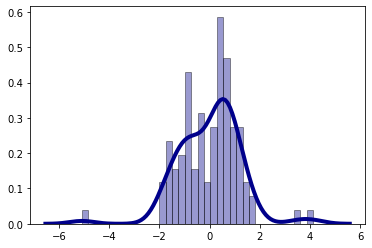

In [74]:
# plot the density curve of error vector
sns.distplot(result.resid, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})


### Implication from the result above:

The density curve above is clearly not a normal distribution,especially on the tails, and the top of the bell shaped curve is on the right hand side of the mean.

In [75]:
# test the 68-95-99.7 rule for the density curve of  error vector
def normal_percent(mean, std):
    count=0;
    for r in result.resid :
        if r>(mean-std) and r<(mean+std):
            count=count+1
    return count

std=np.std(result.resid)
mean=np.mean(result.resid)   

print("68-95-99.7 rule:\n")
print(normal_percent(mean,std), normal_percent(mean,std*2),normal_percent(mean,std*3))

68-95-99.7 rule:

76 97 98


### Implication from the result above:

 from the block above, we see that the density curve of the error vector did not match the 68-95-99.7 rule well.Too much data in the center and too little at the end.

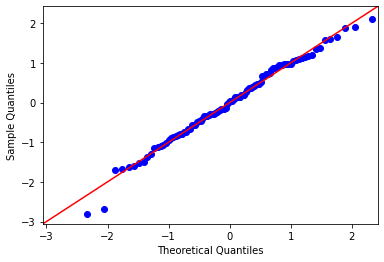

In [76]:
# plot the qq plot for error vector
sm2.qqplot(x, line='45')
pylab.show()

### Implication from the result above:

 From the qq plot above, we see that the error vector is not normally distributed, especially at the tails

In [77]:
# shapiro wilk test
shapiro_test = st.shapiro(result.resid)
shapiro_test

ShapiroResult(statistic=0.938385546207428, pvalue=0.00015389148029498756)

### Implication from the result above:

Null Hypothesis: Error vectors are normally distributed.

Let Alpha = 0.05.

Since the p value from the shaprio wilk test is 0.00015389148029498756, which is smaller than 0.05, the null hypothesis is rejected and the error vector is probably ot normally distributed. 

# Final Conclusion:

 From the density curve, the 68-95-99.7 rule,the qq plot,and the shaprio wilk test that are described above, we can see that all of these indicates that the error vector is not normally distributed. However, it is roughly close to normal.

## (2) & (3)

In [78]:
# Fit the mle with normal assup
def mle_norm(param_vec): 
    b_0 = param_vec[0] 
    b_1 = param_vec[1]
    yhat=b_0+b_1*x
    l= -np.sum(np.log(st.norm.pdf(y - yhat)))
    return l

# Fit the mle with t assup
def mle_t(param_vec):
    b_0 = param_vec[0] 
    b_1 = param_vec[1]
    yhat=b_0+b_1*x
    l= -np.sum(np.log(st.t.pdf(y - yhat,len(x)-2)))
    return l
#optimization(minimization)
model_norm = opt.minimize(mle_norm, np.array([1, 1]))
model_t= opt.minimize(mle_t, np.array([1, 1]))

# calculate the sse for mle_norm and mle_t
e_norm=y-model_norm.x[0]-model_norm.x[1]*x
e_t= y-model_t.x[0]-model_t.x[1]*x
sse_norm=sum(e_norm*e_norm)
sse_t=sum(e_t*e_t)

print("The optimized parameters generated from MlE with assumption of normality:")
print("      β0= ",model_norm.x[0]," β1= ",model_norm.x[1],"\n","     sse= ",sse_norm,"\n")
print("The optimized parameters generated from MlE with assumption of T distributin:")
print("      β0= ",model_t.x[0]," β1= ",model_t.x[1],"\n","     sse= ",sse_t)





The optimized parameters generated from MlE with assumption of normality:
      β0=  0.11983615555152172  β1=  0.6052048075913198 
      sse=  143.61484854062627 

The optimized parameters generated from MlE with assumption of T distributin:
      β0=  0.12325309647619272  β1=  0.5951244996627715 
      sse=  143.6256458563721


# Conclusion 2 and 3 combined:

Since the sse from MLE_t is 143.6256458563721, which is larger than the sse of 143.61484854062627 from MLE_normal , we know that the using MLE given the assumption of normality has the best fit.

The fitted parameters of each are shown in the block above, the parameters from the mle_norm model and mle_t model is close to each other but not the same. We notice that the parameters generated from MLE with assumpotion of normality is the same with those from OLS.

The differences of the parameters from two models and the fact that the parameters generated from MLE with assumpotion of normality is the same with those from OLS indicates that if we break the normality assumption, the value of the estimated parameters would be different and the expected value of y would also be different 




# Problem 3

## (1)

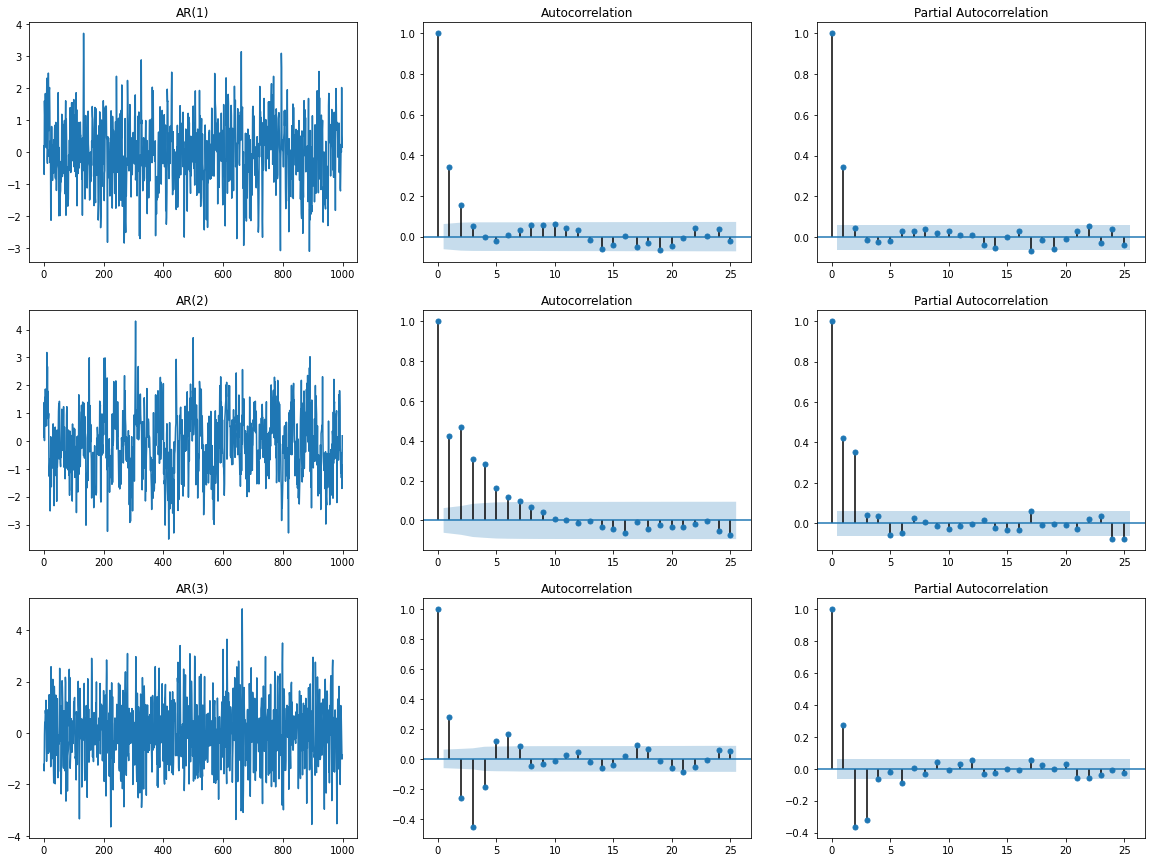

In [79]:
#fit AR process and draw the simulation, ACF and PACF
def ar (p, titles):
    fig, axes=plt.subplots(3,3,figsize=(20,15))
    for i in range(3):
        process = ArmaProcess(ar = p[i])
        data = process.generate_sample(nsample=1000)
        axes[i][0].plot(data)
        axes[i][0].set_title(titles[i])
        fig = plot_acf(data, lags=25, ax=axes[i][1])
        fig = plot_pacf(data, lags=25, ax=axes[i][2]) 
        
ar([[1,-0.3],[1,-0.3,-0.3],[1,-0.3,0.3,0.3]], ["AR(1)","AR(2)","AR(3)"])

## Conclusion 1:

From the graph above we find that only the first lag of the PACF of AR(1)is significantly different from 0; the first and the second lag of the PACF of AR(2)are significantly different from 0; the first,second, and the third lag of AR(3)are significantly different from 0.Therefore the PACF of AR process can be used to determine the order. On the other hand, there is no clear pattern for ACF. 

This feature can also help us to identify if the process is AR or not.


## (2)

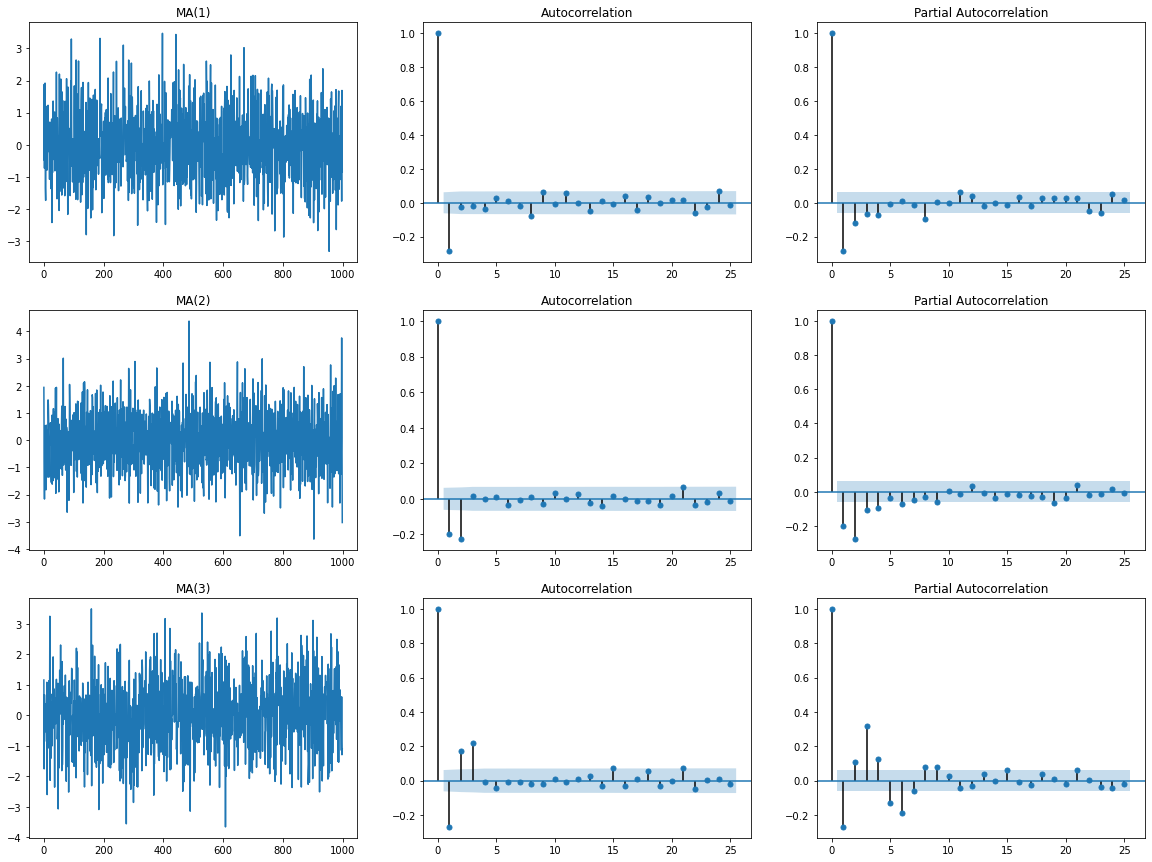

In [80]:
#fit MA process and draw the simulation, ACF and PACF
def ma (p, titles):
    fig, axes=plt.subplots(3,3,figsize=(20,15))
    for i in range(3):
        process = ArmaProcess(ma = p[i])
        data = process.generate_sample(nsample=1000)
        axes[i][0].plot(data)
        axes[i][0].set_title(titles[i])
        fig = plot_acf(data, lags=25, ax=axes[i][1])
        fig = plot_pacf(data,lags=25, ax=axes[i][2])
        
ma([[1,-0.3],[1,-0.3,-0.3],[1,-0.3,0.3,0.3]], ["MA(1)","MA(2)","MA(3)"])

## Conclusion 2:

From the graph above we find that only first lag of the PACF of MA(1)is significantly different from 0; the first and the second lag of the ACF of MA(2)are significantly different from 0; the first,second, and the third lag of MA(3)are significantly different from 0.Therefore the ACF of MA process can be used to determine the order. On the other hand, there is no clear pattern for PACF of MA process. 

Just like from conclusion 1, this feature can also help us to identify if the process is MA or not.

## Final Conclusion(Identify type and order):

So when there is no clear pattern of the ACF but the first n lags of the PACF is significantly different from 0 and the significance of the rest of the lags dcrease intensely, then this might be an AR(n) process.

On the other hand, when there is no clear pattern of the PACF but the first n lags of the ACF is significantly different from 0 and the significance of the rest of the lags dcrease intensely, then this might be a MA(n) process.